In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import struct
import os
from tqdm import tqdm
from tqdm import trange
from tensorflow.python.client import device_lib
from sklearn.svm import SVC
import random
import time

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

# Training Parameters
learning_rate = 0.01
train_epochs = 500
batch_size = 5000

# Network Parameters
num_hidden_1 = 256 # 1st layer num features
num_hidden_2 = 128 # 2nd layer num features
num_hidden_3 = 64 # 3rd layer num features
num_input = 784 # MNIST data input (img shape: 28*28)

# tf Graph input (only pictures)
X = tf.placeholder("float", [None, num_input])
weights = {
    'encoder_h1': tf.Variable(tf.random_normal([num_input, num_hidden_1])),
    'encoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_hidden_2])),
    'encoder_h3': tf.Variable(tf.random_normal([num_hidden_2, num_hidden_3])),
    'decoder_h1': tf.Variable(tf.random_normal([num_hidden_3, num_hidden_2])),
    'decoder_h2': tf.Variable(tf.random_normal([num_hidden_2, num_hidden_1])),
    'decoder_h3': tf.Variable(tf.random_normal([num_hidden_1, num_input])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([num_hidden_1])),
    'encoder_b2': tf.Variable(tf.random_normal([num_hidden_2])),
    'encoder_b3': tf.Variable(tf.random_normal([num_hidden_3])),
    'decoder_b1': tf.Variable(tf.random_normal([num_hidden_2])),
    'decoder_b2': tf.Variable(tf.random_normal([num_hidden_1])),
    'decoder_b3': tf.Variable(tf.random_normal([num_input])),
}

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [2]:
def load_mnist_train(path, kind='train'): 
    labels_path = os.path.join(path, '%s-labels.idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images.idx3-ubyte' % kind)
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath,dtype=np.uint8)
    with open(images_path, 'rb') as imgpath: 
        magic, num, rows, cols = struct.unpack('>IIII',imgpath.read(16)) 
        images = np.fromfile(imgpath,dtype=np.uint8).reshape(len(labels), 784)
    
    return images, labels

In [3]:
def load_mnist_test(path, kind='t10k'): 
    labels_path = os.path.join(path,'%s-labels.idx1-ubyte'% kind) 
    images_path = os.path.join(path,'%s-images.idx3-ubyte'% kind) 
    with open(labels_path, 'rb') as lbpath: 
        magic, n = struct.unpack('>II',lbpath.read(8)) 
        labels = np.fromfile(lbpath,dtype=np.uint8) 
    with open(images_path, 'rb') as imgpath: 
        magic, num, rows, cols = struct.unpack('>IIII',imgpath.read(16)) 
        images = np.fromfile(imgpath,dtype=np.uint8).reshape(len(labels), 784)
    
    return images, labels

In [4]:
path = os.getcwd()
train_images, train_labels = load_mnist_train(path)
test_images, test_labels = load_mnist_test(path)
print(len(train_images))

60000


In [5]:
# Building the encoder
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    # Encoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   biases['encoder_b2']))
    layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['encoder_h3']),
                                   biases['encoder_b3']), name = 'feature')
    return layer_3


In [6]:
# Building the decoder
def decoder(x):
    # Decoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                   biases['decoder_b2']))
    # Decoder Hidden layer with sigmoid activation #3
    layer_3 = tf.add(tf.matmul(layer_2, weights['decoder_h3']),
                                biases['decoder_b3'])
    return layer_3

In [7]:
def check_available_gpus():
    local_devices = device_lib.list_local_devices()
    gpu_names = [x.name for x in device_lib.list_local_devices() if x.device_type == 'GPU']
    gpu_num = len(gpu_names)
    print('{0} GPUs are detected : {1}'.format(gpu_num, gpu_names))
    return gpu_num

In [8]:
# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X
#Define loss and optimizer, minimize the squared error
loss = tf.reduce_mean(tf.pow(y_true- y_pred,2),name = 'loss')
#loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
saver = tf.train.Saver()
check_available_gpus()
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

InternalError: CUDA runtime implicit initialization on GPU:0 failed. Status: out of memory

In [ ]:
def convert_to_one_hot(y,c):
    return np.eye(c)[y.reshape(-1)].T

In [ ]:
if not os.path.exists('tmpnn/'):
    os.mkdir('tmpnn/')
train_x = np.zeros((len(train_images),64))
with tf.Session() as sess:
    if os.path.exists('tmpnn/checkpoint'):
        saver.restore(sess, 'tmpnn/model.ckpt')
    else:
        sess.run(tf.global_variables_initializer())
    total_batch  = int(len(train_images)/batch_size)
    min_lose = float('inf')
    for e in range(train_epochs):
        for b in range(total_batch):
            batch = train_images[b*batch_size:(b+1)*batch_size]
            imgs = batch.reshape((-1,28,28,1))
            feature,batch_cost, _=sess.run([encoder_op,loss, optimizer],feed_dict={X:batch})
            train_x[b*batch_size:(b+1)*batch_size]=feature
            msg = "Global Step={:d}, loss={:.4f}"
            if(batch_cost<min_lose):
                min_lose = batch_cost
                saver.save(sess, 'tmpnn/model.ckpt')
        if e%100 == 99:
            print(msg.format(e,min_lose))


In [9]:
train_y=convert_to_one_hot(train_labels,10)
print(train_x)
print(train_y)

NameError: name 'convert_to_one_hot' is not defined

INFO:tensorflow:Restoring parameters from tmpnn/model.ckpt



100%|██████████| 2/2 [00:00<00:00, 36.96it/s]

Test batch=0, lose=886.3496
Test batch=1, lose=847.7408


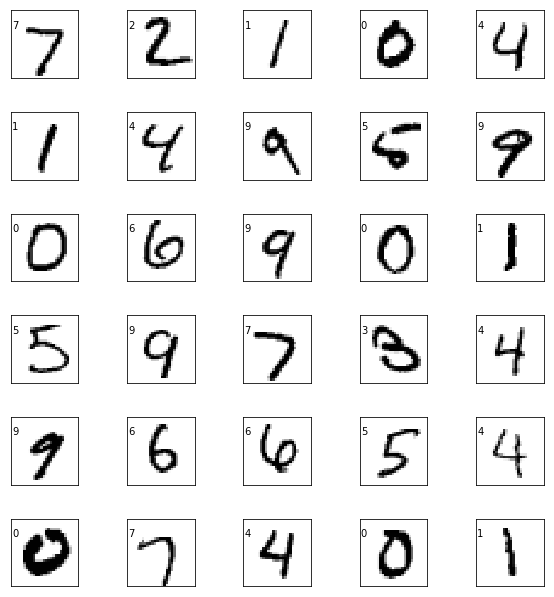

---------------------------------------------------


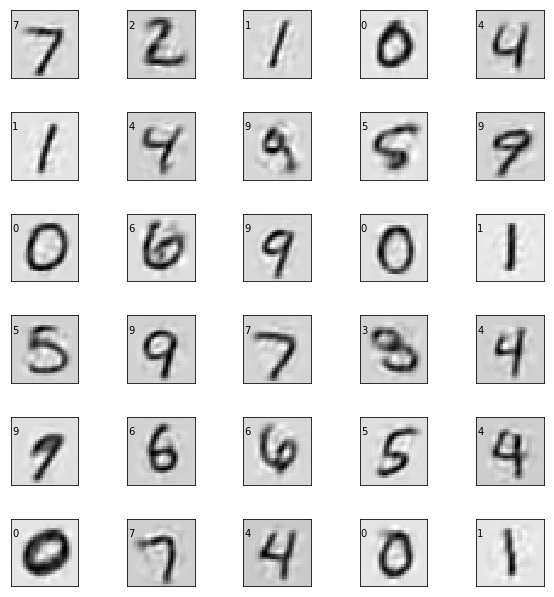

In [63]:
#Test Processing:
test_x = np.zeros((len(test_images),64))
output = []
with tf.Session() as sess:
    if os.path.exists('tmpnn/checkpoint'):        
        saver.restore(sess, 'tmpnn/model.ckpt')
        total_batch  = int(len(test_images)/batch_size)
        msg = "Test batch={:d}, lose={:.4f}"
        for b in tqdm(range(total_batch)):
            batch = test_images[b*batch_size:(b+1)*batch_size]
            imgs = batch.reshape((-1,28,28,1))
            feature,cost,out = sess.run([encoder_op,loss,y_pred], feed_dict={X:batch})
            test_x[b*batch_size:(b+1)*batch_size]=feature
            output.append(out)
            print(msg.format(b,cost))

    else :
        print("Please run training part first")
    fig1 = plt.figure(figsize=(8,8))
    fig1.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.5, wspace=0.05)
    for i in range(30):
        image = np.reshape(test_images[i],[28,28])
        ax=fig1.add_subplot(6,5,i+1,xticks=[],yticks=[]) 
        ax.imshow(image,cmap=plt.cm.binary,interpolation='nearest') 
        ax.text(0,7,str(test_labels[i]))
    plt.show()
    print("---------------------------------------------------")
    fig = plt.figure(figsize=(8,8))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.5, wspace=0.05)
    for i in range(30):
        image = np.reshape(output[0][i],[28,28])
        ax=fig.add_subplot(6,5,i+1,xticks=[],yticks=[]) 
        ax.imshow(image,cmap=plt.cm.binary,interpolation='nearest') 
        ax.text(0,7,str(test_labels[i]))
    plt.show()

In [64]:
test_y=convert_to_one_hot(test_labels,10)
print(test_x)
print(test_y)

[[2.10246161e-01 5.36506593e-01 8.39189112e-01 ... 2.47524232e-01
  4.87482458e-01 6.10230276e-15]
 [5.97138882e-01 7.34344065e-01 8.42841625e-01 ... 2.59402066e-01
  6.69052839e-01 1.09163655e-13]
 [3.19719017e-01 6.72142684e-01 6.94149971e-01 ... 1.25677004e-01
  8.17760289e-01 1.44701529e-15]
 ...
 [2.03252301e-01 4.13320035e-01 7.89139330e-01 ... 3.44286710e-01
  2.08895415e-01 1.09315294e-14]
 [2.97177732e-01 5.64576089e-01 8.39101970e-01 ... 3.47705722e-01
  2.69718438e-01 8.90718777e-16]
 [7.28287518e-01 6.01069152e-01 8.37723851e-01 ... 4.30210173e-01
  5.45573413e-01 1.53615239e-12]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Train RBF network

In [70]:
train_idx = list(range(60000)) 
random.shuffle(train_idx) 
im_sample = train_x[train_idx] 
label_sample = train_labels[train_idx] 

start = time.clock()

clf = SVC(kernel = 'poly') 
clf.fit(im_sample, label_sample) 
elapsed = (time.clock() - start)
print("Time used:",elapsed)


Time used: 225.744776


ValueError: Found input variables with inconsistent numbers of samples: [10, 10000]

In [71]:
score = clf.score(test_x, test_labels) 
print(" score: {:.6f}".format(score))


 score: 0.893100
